## Load DATA

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
%matplotlib widget

In [3]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

Importing plotly failed. Interactive plots will not work.


In [4]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [5]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [6]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [7]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures(include_emmergency_arrivals=True, include_nb_hospit=True),
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [8]:
# Select the target columns to be predicted
# target_colomns = ['nb_emmergencies']
target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [9]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [10]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [11]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x146b3e530>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x146b3e290>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x146b3f850>)],
                  verbose=True)

In [12]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [13]:
features_config_get = {}

In [14]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': 0,
    'targets_rolling_window': 0,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [15]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-27 12:08:50,270: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-27 12:08:50,280: INFO: Initialisation des features
root 2024-11-27 12:08:50,281: INFO: Fetching dataset
hospitalfeatures 2024-11-27 12:08:50,666: INFO: hospitalfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:50,911: INFO: airqualityfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:51,166: INFO: epidemiologicalfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:51,443: INFO: googletrendfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:51,680: INFO: meteorologicalfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:51,925: INFO: sociologicalfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:52,163: INFO: populationfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:52,520: INFO: sportscompetitionfeatures's data already fetched for CHU Dijon
root 2024-11-27 12:08:52,744: INFO:

Dropped 90 constant columns from both sets: {'NO2_FR26010', 'PM10_FR26094', 'PM25_FR26094', 'PM10_FR26010', 'trend_épilepsie', 'NO2_FR26094'}
X shape: (1167, 1800), y shape: (1167, 1)
[ColumnTransformer] .... (1 of 5) Processing pipeline-1, total=   0.1s
[ColumnTransformer] .... (2 of 5) Processing pipeline-2, total=   0.0s


root 2024-11-27 12:08:56,276: INFO: 63 features not encoded (same unit as target)


[ColumnTransformer] .... (3 of 5) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (4 of 5) Processing pipeline-4, total=   0.1s
[ColumnTransformer] .... (5 of 5) Processing pipeline-5, total=   0.1s


In [16]:
df = arsTabularDataset.enc_data
df

,trend_méningite%%J-4,meteo_wspd%%std_365J,trend_rhume%%mean_7J,Y65T69%%J-7,trend_crampes abdominales%%J-7,Y50T54%%mean_14J,trend_otite,meteo_wdir%%J-3,Y_GE95%%J-4,trend_rhume%%std_14J,...,nb_accidents%%J-2,nb_emmergencies%%mean_31J,target_nb_vers_hospit_CHU Dijon%%J+1%%mean_7J%%J-1,nb_accidents%%mean_14J,nb_emmergencies%%std_365J,nb_accidents%%J-1,nb_accidents%%mean_365J,nb_vers_hospit%%mean_14J,nb_accidents%%std_14J,nb_emmergencies%%J-7
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.050247,-0.406075,5.674752,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-02,-0.050247,-0.406075,5.674752,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-03,-0.050247,-0.406075,-0.268277,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-04,-0.050247,-0.406075,-0.268277,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-05,-0.050247,-0.406075,-0.268277,2.083750,-0.050442,-1.309498,-0.09543,1.514694,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,-0.050247,-3.451499,-0.268277,-1.025855,-0.050442,4.768597,-0.09543,0.791576,2.781644,4.184051,...,0.0,181.870968,43.142857,0.0,18.720442,0.0,0.008219,40.642857,0.000000,165.0
2023-12-26,-0.050247,-3.470639,-0.268277,-1.025855,-0.050442,4.771795,-0.09543,0.303690,2.781644,4.184051,...,0.0,182.064516,41.428571,0.0,18.711146,0.0,0.008219,40.500000,0.000000,185.0
2023-12-27,-0.050247,-3.470994,-0.268277,-1.025855,-0.050442,4.775392,-0.09543,0.207855,2.781644,4.184051,...,0.0,182.064516,40.714286,0.0,18.571173,0.0,0.005479,40.428571,0.000000,183.0


In [17]:
# df['target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6'].plot()

In [18]:
df = arsTabularDataset.enc_data
# df.drop('target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6', axis=1, inplace=True)
df

,trend_méningite%%J-4,meteo_wspd%%std_365J,trend_rhume%%mean_7J,Y65T69%%J-7,trend_crampes abdominales%%J-7,Y50T54%%mean_14J,trend_otite,meteo_wdir%%J-3,Y_GE95%%J-4,trend_rhume%%std_14J,...,nb_accidents%%J-2,nb_emmergencies%%mean_31J,target_nb_vers_hospit_CHU Dijon%%J+1%%mean_7J%%J-1,nb_accidents%%mean_14J,nb_emmergencies%%std_365J,nb_accidents%%J-1,nb_accidents%%mean_365J,nb_vers_hospit%%mean_14J,nb_accidents%%std_14J,nb_emmergencies%%J-7
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.050247,-0.406075,5.674752,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-02,-0.050247,-0.406075,5.674752,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-03,-0.050247,-0.406075,-0.268277,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-04,-0.050247,-0.406075,-0.268277,2.083750,-0.050442,-1.309498,-0.09543,1.305600,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
2019-01-05,-0.050247,-0.406075,-0.268277,2.083750,-0.050442,-1.309498,-0.09543,1.514694,-1.837222,3.845134,...,0.0,207.096774,47.714286,0.5,26.347167,0.0,0.561644,47.071429,0.759555,202.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,-0.050247,-3.451499,-0.268277,-1.025855,-0.050442,4.768597,-0.09543,0.791576,2.781644,4.184051,...,0.0,181.870968,43.142857,0.0,18.720442,0.0,0.008219,40.642857,0.000000,165.0
2023-12-26,-0.050247,-3.470639,-0.268277,-1.025855,-0.050442,4.771795,-0.09543,0.303690,2.781644,4.184051,...,0.0,182.064516,41.428571,0.0,18.711146,0.0,0.008219,40.500000,0.000000,185.0
2023-12-27,-0.050247,-3.470994,-0.268277,-1.025855,-0.050442,4.775392,-0.09543,0.207855,2.781644,4.184051,...,0.0,182.064516,40.714286,0.0,18.571173,0.0,0.005479,40.428571,0.000000,183.0


## Trend prediction

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Tuple

In [20]:
def categorize(df, column, bins=[0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0], labels=None, drop=False, offset=0):
    if labels == None and type(bins) == int:
        labels = [f'{i+offset}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i+offset}' for i in range(len(bins) - 1)]
    col_category = (column if drop else f'{column}_category')
    df[col_category] = pd.qcut(df[column], q=bins, labels=labels)
    return df

In [21]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [22]:
def process(dataset, cols, show=False):
    df = dataset.enc_data.copy(deep=True)
    df = df.filter(items=cols)
    df = df.drop(df.loc['2020-03':'2020-05'].index)

    target = dataset.targets_names[0]

    # y = df[target]
    y = dataset.data[target]
    y = y.drop(y.loc['2020-03':'2020-05'].index)
    result = seasonal_decompose(y, model='additive', period=7)

    #cols.append(target)

    df0 = dataset.data.copy(deep=True)
    # df0 = df0.drop('target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6', axis=1)

    df['target'] = result.trend.copy()
    df.dropna(inplace=True)
    # df = categorize(df, 'target', bins=5, drop=True, offset=1)
    # df['target'] = df['target'].astype(float)
    
    if show:
        # Affichage des composantes
        plt.figure(figsize=(10, 9))
        plt.subplot(411)
        plt.plot(y, label='Série temporelle')
        plt.legend(loc='upper left')

        plt.subplot(412)
        plt.plot(result.trend, label='Tendance')
        plt.legend(loc='upper left')


        # print(df['target'])
        # ax3 = plt.subplot(413)  # Capture the Axes for the third subplot
        # plt.plot(df['target'], label='Tendance catégorisée')
        # ax3.set_ylim(sorted(ax3.get_ylim()))  # Corrects the order of y-axis with 0 at the bottom
        # plt.legend(loc='upper left')

        # plt.subplot(413)
        # plt.plot(result.seasonal, label='Saisonnalité')
        # plt.legend(loc='upper left')

        # plt.subplot(414)
        # plt.plot(result.resid, label='Résidu')
        # plt.legend(loc='upper left')
        # plt.tight_layout()
        plt.show()
    
    params = {'eta': 0.05, 
            'objective': 'reg:squarederror', 
            'eval_metric': ['rmse', 'mae'],
            'subsample': 0.7, 
            'colsample_bytree': 1,
            'nthread': -1,
            'device':'cpu'}

    score = 100000
    new_score, reg = teste(df, params, score=score)

    dg = df0.loc[df0.index.year == 2023][:-3]
    dh = df.loc[df.index.year == 2023].drop(columns='target')
    # dg['pred'] = reg.predict(xgb.DMatrix(dh)).round(0) * 30 + dg[target].mean()/2
    dg['pred'] = reg.predict(xgb.DMatrix(dh))
    fig, ax = plt.subplots()
    dg.plot(y=[target, 'pred'], ax=ax)
    # (df.loc[df.index.year == 2023, ['target']][:-3] * 30 + dg[target].mean()/2).plot(ax=ax)
    print(f"MAE: {mean_absolute_error(dg[target], dg['pred']):.2f}")
    
    return reg, dg

In [23]:
def rank_features(dataset):
        params = {'eta': 0.05, 
                'objective': 'reg:absoluteerror', 
                'eval_metric': ['rmse', 'mae'],
                'subsample': 0.7, 
                'colsample_bytree': 1,
                'nthread': -1}

        new_score, bst = teste(dataset, params)

        importance_gain = bst.get_score(importance_type='gain')
        importance_cover = bst.get_score(importance_type='cover')
        importance_weight = bst.get_score(importance_type='weight')
        df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
        df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
        df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])
        df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
        df.fillna(0, inplace=True)
        df['gain_norm'] = df['gain'] / df['gain'].sum()
        df['cover_norm'] = df['cover'] / df['cover'].sum()
        df['weight_norm'] = df['weight'] / df['weight'].sum()
        w_gain = 0.5
        w_cover = 0.3
        w_weight = 0.2
        df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)
        df.sort_values(by='importance', ascending=False, inplace=True)
        df['rank'] = df['importance'].rank(ascending=False)
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'feature'}, inplace=True)
        print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']].head(20))
        return df

Amélioration avec max_depth=3: 100000.0000 -> 58.0128


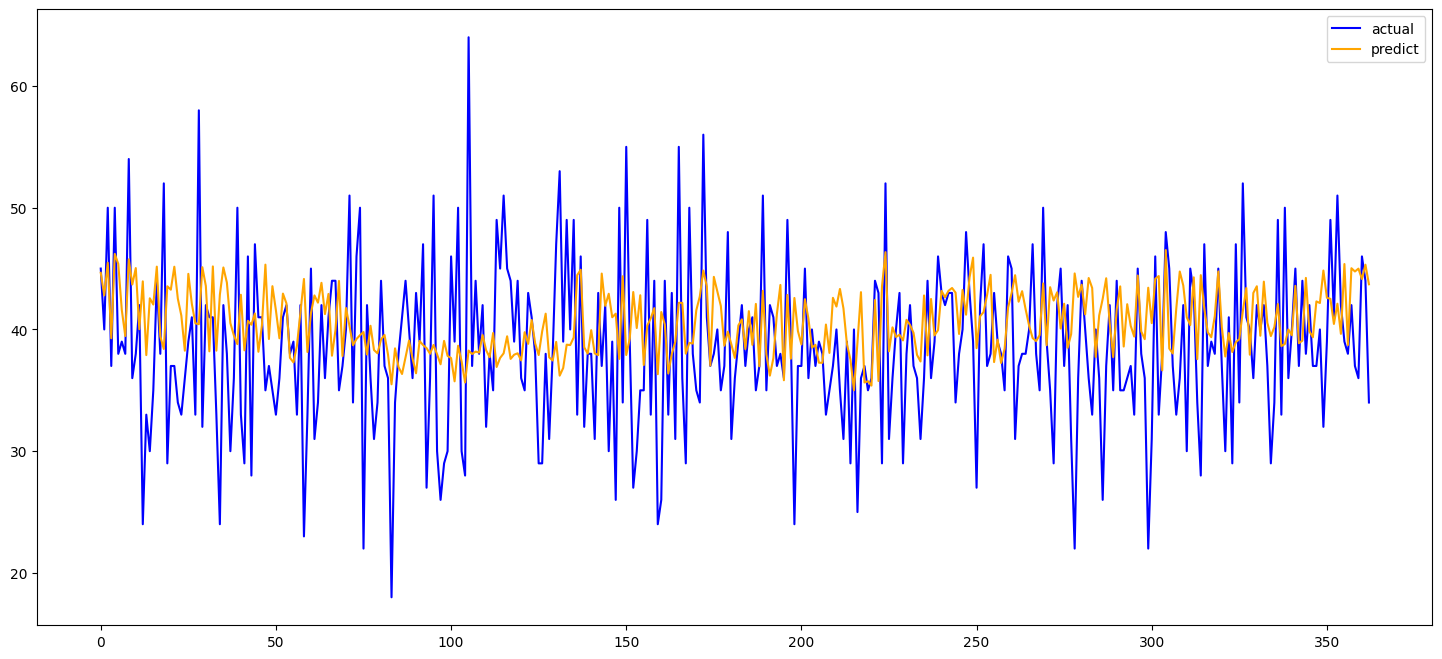

6.06%,1%
10.47%,2%
14.05%,3%
19.83%,4%
25.90%,5%
31.13%,6%
33.61%,7%
36.64%,8%
40.50%,9%
43.25%,10%
45.45%,11%
   - MAE : 5.78 (5.67 sur 2023)
   - MSE : 58.01 (53.36 sur 2023)


KeyboardInterrupt: 

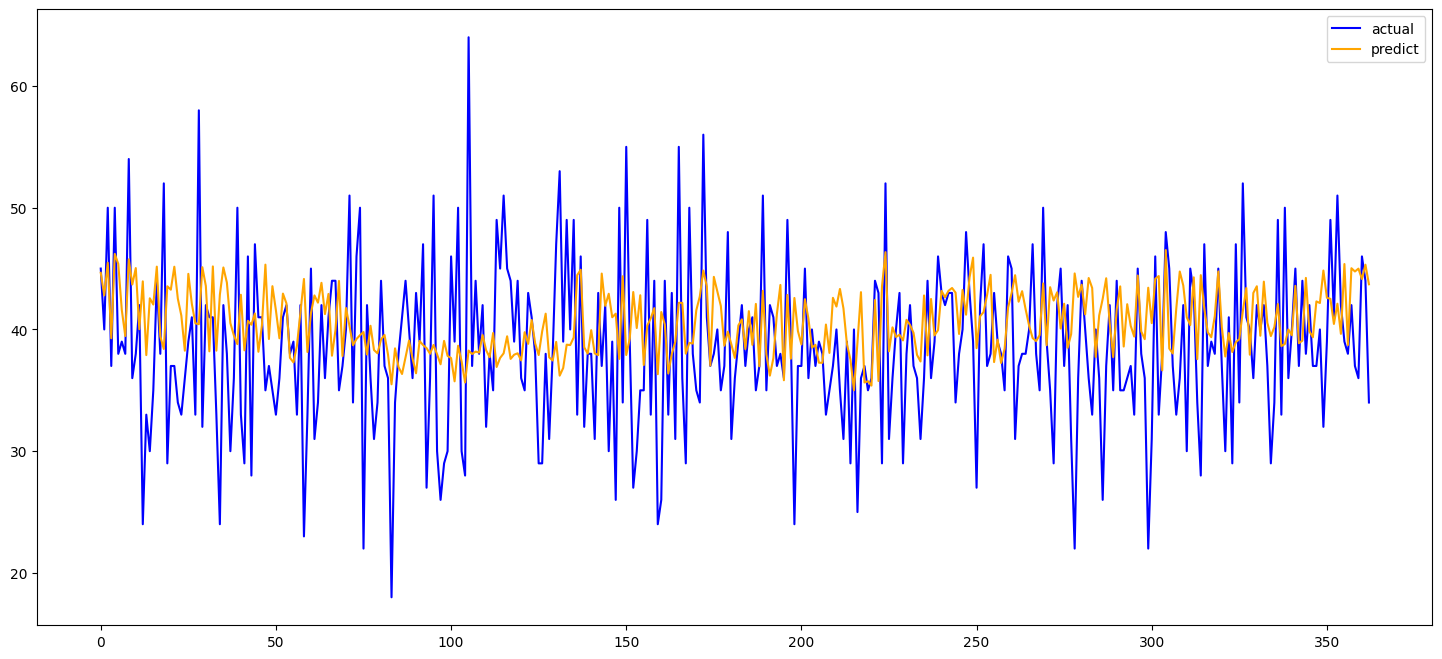

In [24]:
# nb_features = len(arsTabularDataset.enc_data.columns) - 1
cols = arsTabularDataset.enc_data.columns
# while nb_features > 50:
df = arsTabularDataset.enc_data
df['target'] = arsTabularDataset.data[arsTabularDataset.targets_names[0]]
di = rank_features(df)
# rank = int(len(di)/2)
rank = 50

cols = di.loc[di['rank'] < rank, 'feature'].tolist()

# launche all process
reg, pred = process(arsTabularDataset, cols, show=True)


# nb_features = len(cols)


In [ ]:
# reg = process(arsTabularDataset, cols, show=True)